In [1]:
#! module load cuda/11.8.0

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNet, NeuralNetRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from tqdm.auto import tqdm, trange
from sklearn.base import BaseEstimator, TransformerMixin
from skorch.callbacks import EarlyStopping, LRScheduler
from skorch.dataset import Dataset
from skorch.helper import predefined_split
import joblib
# from helpful_functions import log_transform, log_inverse, CustomLogTansformer
# TO-MAKE IMPORTED: log_transform, model class
from helpful_functions import InputLogTransformer, OutputLogTransformer, build_neural_network, make_datasets
import matplotlib.pyplot as plt

In [3]:
spectrum = False
noise = 10
if spectrum:
    num_outputs = 25
    identifier = 'spectrum'
    output_list = ['Bin ' + str(i) for i in range(25)] # training outputs
else:
    num_outputs = 3
    identifier = 'threeEns'
    output_list = ['Max Proton Energy', 'Total Proton Energy', 'Avg Proton Energy']
dfA = pd.read_hdf(f'datasets/fuchs_v5_0_seed-2_train_1274091_noise_{noise}_{identifier}_campaign2.h5', key = 'df')
dfB = pd.read_hdf(f'datasets/fuchs_v5_0_seed-2_train_campaign1_pct_100_noise_{noise}.h5', key='df')
#df = pd.concat([dfA, dfB], ignore_index=True).fillna(0)
df = pd.read_hdf(f'datasets/fuchs_v5_0_seed-2_train_1525000_noise_{noise}_threeEns_.h5', key='df').fillna(0)
df.loc[:, output_list] = df.loc[:, output_list].clip(1e-2, None)
test_df = pd.read_hdf(f'datasets/fuchs_v5_0_seed-2_test_1000000_noise_0_{identifier}_.h5', key = 'df').fillna(0)
test_df.loc[:, output_list] = test_df.loc[:, output_list].clip(1e-2, None)
print(list(df.columns))

['Intensity', 'Pulse Duration', 'Target Thickness', 'Spot Size', 'Focal Distance', 'Contrast', 'Max Proton Energy', 'Total Proton Energy', 'Avg Proton Energy', 'Max Exact Energy', 'Total Exact Energy', 'Avg Exact Energy', 'Laser Energy', 'Conversion Efficiency']


In [4]:
df.sort_values(by="Total Exact Energy", ascending=True)

,Intensity,Pulse Duration,Target Thickness,Spot Size,Focal Distance,Contrast,Max Proton Energy,Total Proton Energy,Avg Proton Energy,Max Exact Energy,Total Exact Energy,Avg Exact Energy,Laser Energy,Conversion Efficiency
1510946,1.000000e+19,40.0,4.5,1.5,2.0,9.448980e-07,0.011899,1.189850e-02,0.011899,3.787863e-19,0.000000e+00,0.000000,0.000014,0.000000
1478195,9.816327e+18,40.0,2.0,1.5,-2.0,9.265306e-07,0.011555,1.155530e-02,0.011555,4.979265e-19,0.000000e+00,0.000000,0.000014,0.000000
1325649,8.897959e+18,40.0,1.5,1.5,-2.0,1.000000e-06,0.010000,1.000000e-02,0.010000,4.565654e-19,0.000000e+00,0.000000,0.000013,0.000000
1388947,9.265306e+18,40.0,4.5,1.5,2.0,9.632653e-07,0.010000,1.000000e-02,0.010000,3.554900e-19,0.000000e+00,0.000000,0.000013,0.000000
1510392,1.000000e+19,40.0,4.0,1.5,1.0,8.714286e-07,0.010564,1.056358e-02,0.010564,4.327795e-19,0.000000e+00,0.000000,0.000014,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515500,1.000000e+19,40.0,0.5,1.5,12.0,1.000000e-07,1.792431,2.133956e+09,0.181187,2.123137e+00,2.527674e+09,0.214616,11.239098,0.036029
1504500,1.000000e+19,40.0,0.5,1.5,-10.0,1.000000e-07,2.192344,2.638424e+09,0.232861,2.110835e+00,2.540330e+09,0.224203,10.900797,0.037333
1514500,1.000000e+19,40.0,0.5,1.5,10.0,1.000000e-07,2.062716,2.482420e+09,0.219092,2.110835e+00,2.540330e+09,0.224203,10.900797,0.037333
1504000,1.000000e+19,40.0,0.5,1.5,-11.0,1.000000e-07,1.823213,2.182225e+09,0.188614,2.122441e+00,2.540375e+09,0.219570,11.076256,0.036742


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
datype = np.float32
num_inputs = 4
batch_size = 2**14

In [6]:
df[output_list].sort_values(by="Total Proton Energy", ascending=False)

,Max Proton Energy,Total Proton Energy,Avg Proton Energy
1514000,2.532453,3.063959e+09,0.277050
1424500,2.675347,3.016959e+09,0.265346
1471500,2.563275,2.962351e+09,0.246348
1444000,2.481079,2.908222e+09,0.270891
1515000,2.428992,2.907288e+09,0.251283
...,...,...,...
1509598,0.010000,1.000000e-02,0.010000
1418699,0.010000,1.000000e-02,0.010000
1295599,0.010000,1.000000e-02,0.010000
1447644,0.010000,1.000000e-02,0.010000


In [7]:
input_list = ['Intensity', 'Target Thickness', 'Focal Distance', 'Contrast'] # independent variables
# testing_list = ['Max Exact Energy', 'Total Exact Energy', 'Avg Exact Energy'] # testing set outputs, deprecated

X = np.array(df[input_list],dtype=datype)
y = np.array(df[output_list],dtype=datype)
X_train, y_train, X_val, y_val, input_transformer, output_transformer = make_datasets(X, y, random_state=42)
train_ds = Dataset(X_train, y_train)
valid_ds = Dataset(X_val, y_val)
X_test = np.array(test_df[input_list],dtype=datype)
y_test = np.array(test_df[output_list],dtype=datype)

In [8]:
model = build_neural_network(valid_ds=valid_ds,device=device, n_inputs = num_inputs, n_outputs = num_outputs, batch_size=batch_size, n_hidden = 12, n_neurons=64, lr=1e-2, gamma=0.85)

In [9]:
#pipe = Pipeline(steps=[('transformer', input_transformer), ('scaler', StandardScaler()), ('model', model)])
#ttr = TransformedTargetRegressor(regressor=pipe, transformer = CustomLogTransformer())
model.fit(train_ds, y=None)

  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1        0.0793        0.0150  0.0100  12.2582
      2        0.0133        0.0132  0.0085  11.4151
      3        0.0125        0.0238  0.0072  11.4593
      4        0.0123        0.0143  0.0061  11.4375
      5        0.0113        0.0115  0.0052  11.5331
      6        0.0110        0.0170  0.0044  11.4476
      7        0.0106        0.0184  0.0038  11.5679
      8        0.0106        0.0110  0.0032  11.4792
      9        0.0106        0.0112  0.0027  11.4568
     10        0.0104        0.0102  0.0023  11.5264
     11        0.0101        0.0099  0.0020  11.4601
     12        0.0100        0.0099  0.0017  11.4774
     13        0.0101        0.0095  0.0014  11.5122
     14        0.0098        0.0094  0.0012  11.4755
     15        0.0097        0.0090  0.0010  11.5611
     16        0.0096        0.0093  0.0009  11.4387
     17        0.0096        0.0092  0.0007  1

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=LDIAModel(
    (norm0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer0): Linear(in_features=4, out_features=64, bias=True)
    (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): LeakyReLU(negative_slope=0.01)
    (layer1): Linear(in_features=64, out_features=64, bias=True)
    (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): LeakyReLU(negative_slope=0.01)
    (layer2): Linear(in_features=64, out_features=64, bias=True)
    (norm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): LeakyReLU(negative_slope=0.01)
    (layer3): Linear(in_features=64, out_features=64, bias=True)
    (norm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act4): LeakyReLU(negative_slope=0.01)
    (layer4): Linear(in_

In [10]:
#X_train = input_transformer.inverse_transform(train_ds.X)
#X_val = input_transformer.inverse_transform(valid_ds.X)
#y_train = output_transformer.inverse_transform(train_ds.y)
#y_val = output_transformer.inverse_transform(valid_ds.y)
y_pred = output_transformer.inverse_transform(model.predict(valid_ds.X))
y_train_pred = output_transformer.inverse_transform(model.predict(train_ds.X))
y_train_true = output_transformer.inverse_transform(y_train)
correction_factors = []
for i in range(num_outputs):
    α = np.mean(y_train_true[:, i]/y_train_pred[:, i])
    correction_factors.append(α)
y_train_pred_corrected = y_train_pred.copy()
for i in range(num_outputs):
    y_train_pred_corrected[:, i] *= correction_factors[i]

In [11]:
y_train_pred_corrected

array([[1.0429897e-02, 2.6097498e+02, 1.0449347e-02],
       [1.6778333e-02, 6.8618619e+05, 1.0414169e-02],
       [4.3855570e-02, 4.5065115e+06, 1.2764118e-02],
       ...,
       [6.2486663e-02, 3.8833370e+06, 1.6602393e-02],
       [4.5722264e-01, 1.9068675e+08, 7.0745535e-02],
       [4.7651112e-02, 2.3839662e+06, 1.1996458e-02]], dtype=float32)

In [12]:
y_train_pred

array([[1.0374033e-02, 2.5882617e+02, 1.0395469e-02],
       [1.6688464e-02, 6.8053631e+05, 1.0360472e-02],
       [4.3620672e-02, 4.4694060e+06, 1.2698304e-02],
       ...,
       [6.2151972e-02, 3.8513628e+06, 1.6516790e-02],
       [4.5477366e-01, 1.8911669e+08, 7.0380762e-02],
       [4.7395885e-02, 2.3643372e+06, 1.1934603e-02]], dtype=float32)

In [13]:
X_train = input_transformer.inverse_transform(train_ds.X)
X_val = input_transformer.inverse_transform(valid_ds.X)
y_train = output_transformer.inverse_transform(train_ds.y)
y_val = output_transformer.inverse_transform(valid_ds.y)
y_train_pred = output_transformer.inverse_transform(model.predict(train_ds.X))
y_train_pred

array([[1.0374033e-02, 2.5882617e+02, 1.0395469e-02],
       [1.6688464e-02, 6.8053631e+05, 1.0360472e-02],
       [4.3620672e-02, 4.4694060e+06, 1.2698304e-02],
       ...,
       [6.2151972e-02, 3.8513628e+06, 1.6516790e-02],
       [4.5477366e-01, 1.8911669e+08, 7.0380762e-02],
       [4.7395885e-02, 2.3643372e+06, 1.1934603e-02]], dtype=float32)

In [14]:
df1 = pd.DataFrame(X_train,columns=input_list)
df2 = pd.DataFrame(X_val, columns=input_list)
df1 = pd.concat((df1, pd.DataFrame(y_train_pred,columns=output_list)),axis=1)
df2 = pd.concat((df2, pd.DataFrame(y_pred,columns=output_list)),axis=1)
df1.insert(0, "color", "red")
df2.insert(0, "color", "blue")

In [15]:
X_test_scaled = input_transformer.transform(X_test)
y_test_pred = output_transformer.inverse_transform(model.predict(X_test_scaled))
y_test_pred_corrected = y_test_pred.copy()
for i in range(num_outputs):
    y_test_pred_corrected[:, i] *= correction_factors[i]

In [16]:
print("Model performance on blind randomized testing data:", mean_absolute_percentage_error(y_test, y_test_pred)*100)
print("Corrected model performance on blind randomized testing data:", mean_absolute_percentage_error(y_test, y_test_pred_corrected)*100)

Model performance on blind randomized testing data: 1.731543242931366
Corrected model performance on blind randomized testing data: 1.6849465668201447


In [17]:
# thickness = 0.5
# preddf1 = df1[(np.round(df1["Thickness"],2)==thickness) & (df1["Intensity"]>9.999e+18)]
# preddf2 = df2[(np.round(df2["Thickness"],2)==thickness) & (df2["Intensity"]>9.999e+18)]
# #X_coord = preddf["Focus"].to_numpy()
# #y_coord = preddf["Max"].to_numpy()
# exactdf = df[(df["Target Thickness"]==thickness) & (df["Intensity"]==1e19)].drop_duplicates(subset=["Target Thickness", "Focal Distance", "Intensity"]).sort_values(by="Focal Distance")
# X_exact = exactdf["Focal Distance"].to_numpy()
# y_exact = exactdf["Max Exact Energy"].to_numpy()
# y_noisy = exactdf["Max Proton Energy"].to_numpy()
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(nrows=1, ncols=1)
# ax.scatter(preddf1['Focus'], preddf1['Max'], c=preddf1["color"],label='Training')
# ax.scatter(preddf2['Focus'], preddf2['Max'], c=preddf2["color"],marker="*",label='Testing')
# #ax.scatter(X_coord, y_coord,color=colors)
# ax.plot(X_exact,y_exact, color='gray',linestyle='--',marker=".",label="Fuchs")
# ax.scatter(X_exact,y_noisy, color='green',marker="^",label="Noisy Fuchs")
# ax.legend(loc='upper right')

In [18]:
mean_absolute_percentage_error(y_pred, y_val)

0.0805681

In [19]:
input_list

['Intensity', 'Target Thickness', 'Focal Distance', 'Contrast']

In [20]:
correction_factors

[1.005385, 1.0083021, 1.0051829]

In [21]:
y_test.shape

(1000000, 3)

In [22]:
X_test_scaled.shape

(1000000, 4)

In [23]:
y_test_pred.shape

(1000000, 3)

In [24]:
df_testing_1 = pd.DataFrame(y_test, columns = ["Max Actual Energy", "Tot Actual Energy", "Avg Actual Energy"])
df_testing_2 = pd.DataFrame(y_test_pred, columns = ["Max Predicted Energy", "Tot Predicted Energy", "Avg Predicted Energy"])
df_testing = pd.concat([df_testing_1, df_testing_2], axis=1)
df_testing

,Max Actual Energy,Tot Actual Energy,Avg Actual Energy,Max Predicted Energy,Tot Predicted Energy,Avg Predicted Energy
0,0.305085,6.293781e+07,0.054705,0.304314,6.257650e+07,0.053921
1,0.131275,9.195308e+06,0.029566,0.132635,9.008228e+06,0.029385
2,0.173750,3.072579e+07,0.038441,0.174178,3.176169e+07,0.038572
3,0.053282,3.906940e+06,0.014945,0.054564,3.850415e+06,0.015070
4,0.167539,2.366475e+07,0.038440,0.161756,2.174407e+07,0.037833
...,...,...,...,...,...,...
999995,0.386244,9.299533e+07,0.068241,0.365476,8.833578e+07,0.065451
999996,0.208952,5.449576e+07,0.042170,0.210921,5.657006e+07,0.042041
999997,0.584773,2.969735e+08,0.087542,0.583808,2.995505e+08,0.087027
999998,0.044741,1.683920e+06,0.011255,0.043752,1.669718e+06,0.011277


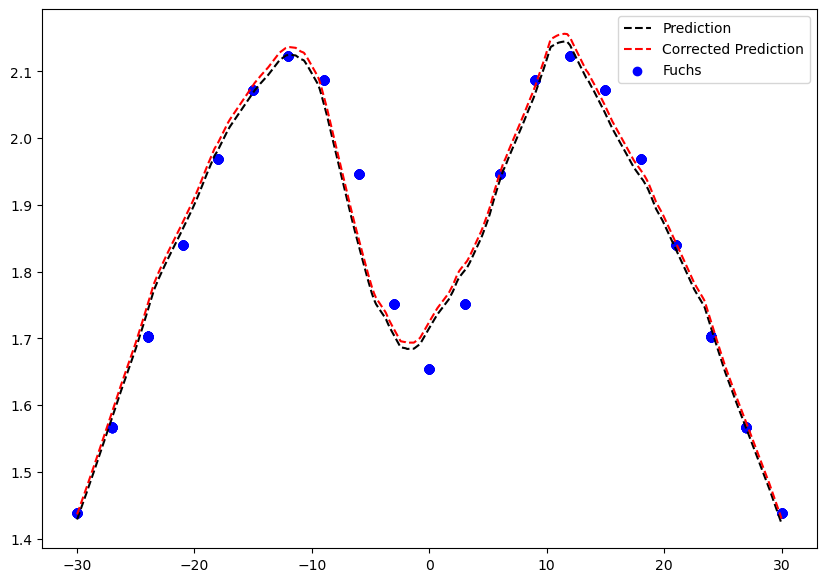

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
if spectrum:
    thickness = 0.5
    intens = 1e19
    foc = 0.0
    contrast = 1e-7
    #exactdf = dfB[(dfB["Target Thickness"]==thickness) & (dfB["Intensity"]==intens) & (dfB["Focal Distance"]==foc) & (dfB["Contrast"]==contrast) ].drop_duplicates(subset=["Target Thickness", "Focal Distance", "Intensity"]).iloc[0]
    exactdf = test_df.sample(n=1)
    spectrum_exact = np.array(exactdf[output_list], dtype=datype).flatten()
    X_in = input_transformer.transform(np.array(exactdf[input_list], dtype=datype).flatten().reshape(1, -1))
    spectrum_pred = model.predict(X_in)
    spectrum_pred = output_transformer.inverse_transform(spectrum_pred).flatten()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    edges = np.arange(0, 5.01, 0.2, dtype=datype) # don't ask
    for i in range(2):
        ax[i].set_xlabel('Proton Energy (MeV)')
        ax[i].stairs(spectrum_exact, edges, fill=False, color='black', label='exact')
        ax[i].stairs(spectrum_pred, edges, fill=True, color='red', alpha=0.5, label='prediction')
    ax[0].legend(loc='upper right')
    ax[0].set_ylabel('Counts per Energy Bin')
    ax[1].set_yscale('log')
    ax[0].set_title('Proton Spectrum Linear Axes')
    ax[1].set_title('Proton Spectrum Log-Linear')
    fig.savefig('energy_spectrum.png')
else:
    thickness = 0.5
    #X_coord = preddf["Focus"].to_numpy()
    #y_coord = preddf["Max"].to_numpy()
    intensity = 1e19
    dx = 0.005
    dI = 1e16
    contrast = 1e-7
    dC = 1e-9
    focus_dip = np.linspace(-30, 30, 1000)
    intens_dip = np.ones(1000)*intensity
    thickness_dip = np.ones(1000)*thickness
    contrast_dip = np.ones(1000)*contrast

    dip_params = np.array([intens_dip, thickness_dip, focus_dip, contrast_dip], dtype=datype).T

    dip_params_scaled = input_transformer.transform(dip_params)
    dip_preds = output_transformer.inverse_transform(model.predict(dip_params_scaled))
    max_dip = dip_preds[:, 0]
    exactdf = dfB[(dfB["Target Thickness"]>thickness-dx) & (dfB["Target Thickness"] < thickness+dx) & (dfB["Intensity"]<intensity+dI) & (dfB["Intensity"] > intensity-dI)].drop_duplicates(subset=["Target Thickness", "Focal Distance", "Intensity"]).sort_values(by="Focal Distance")
    #exactdf = df[(df["Target Thickness"]>thickness-dx) & (df["Target Thickness"] < thickness+dx) & (df["Intensity"]<intensity+dI) & (df["Intensity"] > intensity-dI) & (df["Contrast"] > contrast-dC) & (df["Contrast"] < contrast+dC)].drop_duplicates(subset=["Target Thickness", "Focal Distance", "Intensity"]).sort_values(by="Focal Distance")
    #exactdf = test_df[(test_df["Target Thickness"]==thickness) & (test_df["Intensity"]==1e19)].drop_duplicates(subset=["Target Thickness", "Focal Distance", "Intensity"]).sort_values(by="Focal Distance")
    y_pred0_corrected = np.zeros_like(dip_preds)
    for i in range(len(correction_factors)):
        y_pred0_corrected[:, i] = dip_preds[:, i] * correction_factors[i]
    #if GPU:
    #    y_pred0 = output_transformer.inverse_transform(np.concatenate((modelA.predict(X0).get().reshape(-1, 1), modelB.predict(X0).get().reshape(-1, 1), modelC.predict(X0).get().reshape(-1, 1)), axis=1))
    #if CPU:
    #   y_pred0 = output_transformer.inverse_transform(np.concatenate((modelA.predict(poly.transform(X0)).reshape(-1, 1), modelB.predict(poly.transform(X0)).reshape(-1, 1), modelC.predict(poly.transform(X0)).reshape(-1, 1)), axis=1))
    X_exact = exactdf["Focal Distance"].to_numpy()
    y_exact = exactdf["Max Exact Energy"].to_numpy()
    y_noisy = exactdf["Max Proton Energy"].to_numpy()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
    ax.plot(focus_dip, max_dip, color='black', linestyle='--',label='Prediction')
    ax.plot(focus_dip, y_pred0_corrected[:, 0], linestyle='--',color='red',label='Corrected Prediction')
    #ax.scatter(preddf2['Focus'], preddf2['Max'], c=preddf2["color"],marker="*",label='Testing')
    #ax.scatter(X_coord, y_coord,color=colors)
    ax.scatter(X_exact,y_exact, color='blue',label="Fuchs")
    #ax.scatter(X_exact,y_noisy, color='green',marker="^",label="Noisy Fuchs")
    ax.legend(loc='upper right')

In [26]:
import joblib
from datetime import datetime
stamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
model_name = "Neural Net " + stamp + ".pth"
out_name = "Output Transformer " + stamp + ".sav"
in_name = "Input Transformer " + stamp + ".sav"

torch.save(model.module_.state_dict(), model_name)
joblib.dump(input_transformer, in_name)
joblib.dump(output_transformer, out_name)

['Output Transformer 2024-07-24-12-32-24.sav']

In [27]:
exactdf

,Intensity,Pulse Duration,Target Thickness,Spot Size,Focal Distance,Contrast,Max Proton Energy,Total Proton Energy,Avg Proton Energy,Max Exact Energy,Total Exact Energy,Avg Exact Energy,Laser Energy,Conversion Efficiency
10201,9.992240e+18,40.0,0.5,1.5,-30.0,1.000000e-07,1.494570,1.749810e+09,0.141156,1.437700,1.683228e+09,0.135785,12.746883,0.021154
66390,9.994030e+18,40.0,0.5,1.5,-30.0,1.000000e-07,1.259874,1.475266e+09,0.118986,1.437858,1.683677e+09,0.135795,12.749043,0.021156
128952,9.999140e+18,40.0,0.5,1.5,-30.0,1.000000e-07,1.741768,2.040461e+09,0.164482,1.438307,1.684959e+09,0.135825,12.755209,0.021162
275770,9.997990e+18,40.0,0.5,1.5,-30.0,1.000000e-07,1.360094,1.593173e+09,0.128441,1.438206,1.684671e+09,0.135818,12.753821,0.021161
514308,9.999530e+18,40.0,0.5,1.5,-30.0,1.000000e-07,1.477679,1.731143e+09,0.139542,1.438341,1.685057e+09,0.135827,12.755679,0.021163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643892,9.998840e+18,40.0,0.5,1.5,30.0,1.000000e-07,1.351132,1.582793e+09,0.127593,1.438280,1.684884e+09,0.135823,12.754847,0.021162
643121,9.999460e+18,40.0,0.5,1.5,30.0,1.000000e-07,1.476006,1.729171e+09,0.139384,1.438335,1.685040e+09,0.135826,12.755595,0.021163
95703,9.990820e+18,40.0,0.5,1.5,30.0,1.000000e-07,1.471627,1.722734e+09,0.138993,1.437575,1.682872e+09,0.135776,12.745169,0.021153
736188,9.999600e+18,40.0,0.5,1.5,30.0,1.000000e-07,1.457992,1.708089e+09,0.137682,1.438347,1.685075e+09,0.135827,12.755764,0.021163


In [28]:
test_df

,Intensity,Pulse Duration,Target Thickness,Spot Size,Focal Distance,Contrast,Max Proton Energy,Total Proton Energy,Avg Proton Energy,Max Exact Energy,Total Exact Energy,Avg Exact Energy,Laser Energy,Conversion Efficiency
0,2.728946e+18,40.0,0.501061,1.5,22.057500,5.449403e-07,0.305085,6.293781e+07,0.054705,0.305085,6.293781e+07,0.054705,3.253105,0.003099
1,1.061515e+18,40.0,3.647437,1.5,-12.166962,2.089268e-07,0.131275,9.195308e+06,0.029566,0.131275,9.195308e+06,0.029566,1.357105,0.001085
2,3.545377e+18,40.0,1.775006,1.5,18.377275,7.631194e-07,0.173750,3.072579e+07,0.038441,0.173750,3.072579e+07,0.038441,3.777053,0.001303
3,2.724723e+18,40.0,4.972923,1.5,3.073450,5.673503e-07,0.053282,3.906940e+06,0.014945,0.053282,3.906940e+06,0.014945,2.288052,0.000274
4,2.632496e+18,40.0,1.425241,1.5,-11.334392,6.640953e-07,0.167539,2.366475e+07,0.038440,0.167539,2.366475e+07,0.038440,2.675632,0.001417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2.817837e+18,40.0,3.035819,1.5,-15.761103,1.603021e-07,0.386244,9.299533e+07,0.068241,0.386244,9.299533e+07,0.068241,3.530968,0.004219
999996,4.603842e+18,40.0,4.797633,1.5,-29.334765,1.880939e-07,0.208952,5.449576e+07,0.042170,0.208952,5.449576e+07,0.042170,5.904605,0.001479
999997,6.093010e+18,40.0,2.521640,1.5,-25.265180,1.601187e-07,0.584773,2.969735e+08,0.087542,0.584773,2.969735e+08,0.087542,7.642733,0.006225
999998,1.018077e+18,40.0,2.217583,1.5,-28.210175,8.617917e-07,0.044741,1.683920e+06,0.011255,0.044741,1.683920e+06,0.011255,1.299957,0.000208


In [29]:
df["Contrast"]

0          1.000000e-07
1          1.183673e-07
2          1.367347e-07
3          1.551020e-07
4          1.734694e-07
               ...     
1524995    9.265306e-07
1524996    9.448980e-07
1524997    9.632653e-07
1524998    9.816327e-07
1524999    1.000000e-06
Name: Contrast, Length: 1525000, dtype: float64

In [30]:
import numpy as np
np.arange(0, 5.01, 0.2)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ])

In [31]:
model.module_.load_state_dict(torch.load(model_name))

<All keys matched successfully>